In [ ]:
# Clone the repository
!git clone https://github.com/sveitser/kaggle_diabetic.git

# Navigate to the repository directory
%cd kaggle_diabetic
# Install dependencies
!pip install -r requirements.txt
!pip install tensorflow keras opencv-python matplotlib numpy pandas scikit-learn

Cloning into 'kaggle_diabetic'...
remote: Enumerating objects: 1554, done.
remote: Total 1554 (delta 0), reused 0 (delta 0), pack-reused 1554 (from 1)
Receiving objects: 100% (1554/1554), 350.86 KiB | 1.19 MiB/s, done.
Resolving deltas: 100% (1279/1279), done.
/content/kaggle_diabetic
Obtaining Lasagne-master from git+https://github.com/benanne/Lasagne.git@9f591a5f3a192028df9947ba1e4903b3b46e8fe0#egg=Lasagne-master (from -r requirements.txt (line 3))
  Cloning https://github.com/benanne/Lasagne.git (to revision 9f591a5f3a192028df9947ba1e4903b3b46e8fe0) to ./src/lasagne-master
  Running command git clone --filter=blob:none --quiet https://github.com/benanne/Lasagne.git /content/kaggle_diabetic/src/lasagne-master
  Running command git rev-parse -q --verify 'sha^9f591a5f3a192028df9947ba1e4903b3b46e8fe0'
  Running command git fetch -q https://github.com/benanne/Lasagne.git 9f591a5f3a192028df9947ba1e4903b3b46e8fe0
  Running command git checkout -q 9f591a5f3a192028df9947ba1e4903b3b46e8fe0
  

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vishvasrsrivastava","key":"76b0376c92ba30c641cd4d659cf85253"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle competitions download -c diabetic-retinopathy-detection
!kaggle competitions download -c diabetic-retinopathy-classification-f1-score-4
!7z x diabetic-retinopathy-classification-f1-score-4.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 623713790 bytes (595 MiB)

Extracting archive: diabetic-retinopathy-classification-f1-score-4.zip
--
Path = diabetic-retinopathy-classification-f1-score-4.zip
Type = zip
Physical Size = 623713790

  0%      2% 81 - kaggle_retina/test/0f882877bf13.png                                               5% 163 - kaggle_retina/test/1d55e689cf84.png                                                7% 259 - kaggle_retina/test/2db0cd3e30da.png                                              

In [ ]:
import random
import numpy as np
import tensorflow as tf
seed=7
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

labels = pd.read_csv('/content/kaggle_diabetic/kaggle_retina/train.csv')
# Rename columns and add ".jpeg" extension
labels.columns = ['image', 'level']
labels['image'] = labels['image'] + '.png'  # Add extension here
labels['level'] = labels['level'].astype(str)
labels

,image,level
0,c1e6fa1ad314.png,1
1,ed246ae1ed08.png,1
2,4d3de40ced3a.png,0
3,ae8472f8d310.png,1
4,3c28fd846b43.png,0
...,...,...
2192,87774aafe068.png,1
2193,1b4625877527.png,1
2194,bfe467b7e997.png,1
2195,d2cd47ed2c1d.png,0


Found 1752 validated image filenames belonging to 2 classes.
Found 437 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 8 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 8 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


<Axes: xlabel='level'>

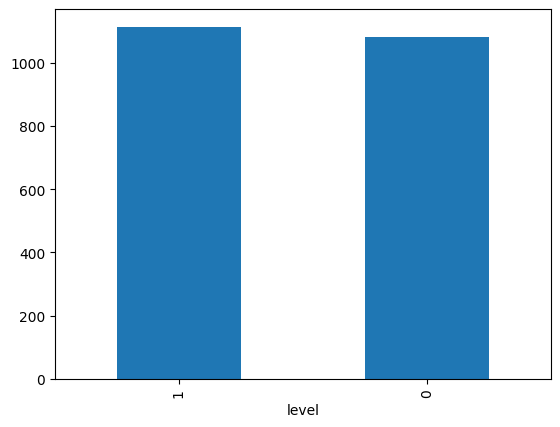

In [ ]:
#data preprocessing
import cv2
import numpy as np
from tensorflow.keras.applications.densenet import preprocess_input
#detect and correct inverted images
def fix_inversion(image_path):
    image = cv2.imread(image_path)
    # Check for inversion using macula position or notch presence
    # (Implement your inversion detection logic here)
    if is_inverted(image):
        image = cv2.flip(image, 0)  # Flip vertically
    return image
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A
# Assuming labels are 0 (No Disease) and 1 (Disease)
class_weights = {0: 1.0, 1: 5.0}
# Use albumentations for advanced augmentation
def augment(image):
    return A.Compose([
        A.RandomRotate90(),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussianBlur(p=0.1),
        A.CLAHE(p=0.1),
    ])(image=image)["image"]

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Use DenseNet's built-in preprocessing
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/kaggle_diabetic/kaggle_retina/train',  # Path to your images
    x_col='image',                    # Column with filenames
    y_col='level',                    # Column with labels
    target_size=(256, 256),
    class_mode='binary',
    batch_size=32,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/kaggle_diabetic/kaggle_retina/train',
    x_col='image',
    y_col='level',
    target_size=(256, 256),
    class_mode='binary',
    batch_size=32,
    subset='validation'
)
labels['level'].value_counts().plot(kind='bar')

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions to 0/1
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()
def focal_loss(gamma=0.5, alpha=0.75):  # Higher alpha for Class 1
    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss)
    return loss_fn

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.regularizers import l2
# Load ResNet50 pretrained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze pretrained layers
base_model.trainable = True

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(1, activation='sigmoid',kernel_regularizer=l2(0.1))(x)  # Replace the 5-class output

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(
    optimizer='adam',
    loss=focal_loss(),  # Replace sparse_categorical_crossentropy
    metrics=['accuracy', F1Score()]  # Custom F1Score (see below)
)

In [ ]:
history = model.fit(train_generator,
    validation_data=val_generator, batch_size = 128, epochs = 20, verbose = 1, callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_model123.h5', save_best_only=True)
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.5123 - f1_score: 0.6719 - loss: 0.1697

55/55 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.5123 - f1_score: 0.6720 - loss: 0.1688 - val_accuracy: 0.4805 - val_f1_score: 0.6491 - val_loss: 0.0498
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5187 - f1_score: 0.6824 - loss: 0.0358

55/55 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.5186 - f1_score: 0.6823 - loss: 0.0356 - val_accuracy: 0.4805 - val_f1_score: 0.6491 - val_loss: 0.0100
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5359 - f1_score: 0.6976 - loss: 0.0070

55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5355 - f1_score: 0.6973 - loss: 0.0070 - val_accuracy: 0.4805 - val_f1_score: 0.6491 - val_loss: 0.0021
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5224 - f1_score: 0.6862 - loss: 0.0016

55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.5223 - f1_score: 0.6861 - loss: 0.0016 - val_accuracy: 0.4805 - val_f1_score: 0.6491 - val_loss: 5.6769e-04
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5297 - f1_score: 0.6924 - loss: 4.6715e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5294 - f1_score: 0.6922 - loss: 4.6541e-04 - val_accuracy: 0.4805 - val_f1_score: 0.6491 - val_loss: 1.9194e-04
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5111 - f1_score: 0.6762 - loss: 1.7598e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5112 - f1_score: 0.6763 - loss: 1.7549e-04 - val_accuracy: 0.4805 - val_f1_score: 0.6491 - val_loss: 1.0211e-04
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5233 - f1_score: 0.6864 - loss: 9.8025e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5231 - f1_score: 0.6863 - loss: 9.7853e-05 - val_accuracy: 0.4805 - val_f1_score: 0.6491 - val_loss: 6.0039e-05
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4898 - f1_score: 0.6572 - loss: 7.1870e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4902 - f1_score: 0.6576 - loss: 7.1778e-05 - val_accuracy: 0.4805 - val_f1_score: 0.6491 - val_loss: 5.1586e-05
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5209 - f1_score: 0.6850 - loss: 5.5681e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5208 - f1_score: 0.6849 - loss: 5.5643e-05 - val_accuracy: 0.4805 - val_f1_score: 0.6491 - val_loss: 4.6072e-05
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.5170 - f1_score: 0.6811 - loss: 4.7300e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5170 - f1_score: 0.6811 - loss: 4.7275e-05 - val_accuracy: 0.4805 - val_f1_score: 0.6491 - val_loss: 4.0254e-05
Epoch 11/20
45/55 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5107 - f1_score: 0.6759 - loss: 4.2286e-05

KeyboardInterrupt: 

Text(0.5, 1.0, 'Accuracy evolution through ResNet50')

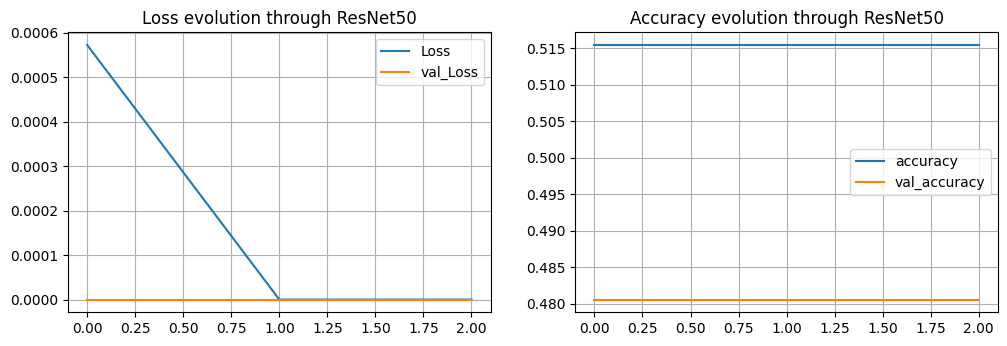

In [ ]:
#Visualizing the training performance
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution through ResNet50')
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution through ResNet50')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true labels and predicted probabilities
val_true = val_generator.labels  # True labels
val_pred_probs = model.predict(val_generator)  # Predicted probabilities
val_pred = np.argmax(val_pred_probs, axis=1)  # Convert to class labels (0-4)

# Generate classification report
print("Classification Report:")
print(classification_report(val_true, val_pred, target_names=['0', '1']))


14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 527ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       227
           1       0.00      0.00      0.00       210

    accuracy                           0.52       437
   macro avg       0.26      0.50      0.34       437
weighted avg       0.27      0.52      0.36       437



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
# Load DenseNet121
base_model3 = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x3 = GlobalAveragePooling2D()(base_model3.output)
output3 = Dense(1, activation='sigmoid')(x3)
model3 = Model(inputs=base_model3.input, outputs=output3)

# Compile and train
model3.compile(tf.keras.optimizers.Adam(1e-5),loss=focal_loss(),metrics=['accuracy', F1Score(), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
history3 = model3.fit(train_generator, validation_data=val_generator, epochs=25, verbose = 1, callbacks=[
        tf.keras.callbacks.ModelCheckpoint('densenet121_model.h5', save_best_only=True)
    ])

# Save the model
model3.save('densenet121_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5598 - f1_score: 0.7002 - loss: 0.2605 - precision: 0.5392 - recall: 0.9999

55/55 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.5610 - f1_score: 0.7008 - loss: 0.2598 - precision: 0.5399 - recall: 0.9999 - val_accuracy: 0.5698 - val_f1_score: 0.6898 - val_loss: 0.2382 - val_precision: 0.5278 - val_recall: 0.9952
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7805 - f1_score: 0.8173 - loss: 0.1392 - precision: 0.7038 - recall: 0.9792

55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7816 - f1_score: 0.8181 - loss: 0.1386 - precision: 0.7051 - recall: 0.9790 - val_accuracy: 0.8421 - val_f1_score: 0.8553 - val_loss: 0.1095 - val_precision: 0.7640 - val_recall: 0.9714
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8914 - f1_score: 0.9001 - loss: 0.0727 - precision: 0.8477 - recall: 0.9593

55/55 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8915 - f1_score: 0.9001 - loss: 0.0726 - precision: 0.8478 - recall: 0.9594 - val_accuracy: 0.8741 - val_f1_score: 0.8822 - val_loss: 0.0753 - val_precision: 0.8016 - val_recall: 0.9810
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9042 - f1_score: 0.9108 - loss: 0.0563 - precision: 0.8587 - recall: 0.9701

55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9041 - f1_score: 0.9107 - loss: 0.0563 - precision: 0.8587 - recall: 0.9699 - val_accuracy: 0.8902 - val_f1_score: 0.8943 - val_loss: 0.0577 - val_precision: 0.8320 - val_recall: 0.9667
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9041 - f1_score: 0.9106 - loss: 0.0453 - precision: 0.8514 - recall: 0.9793

55/55 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9042 - f1_score: 0.9107 - loss: 0.0454 - precision: 0.8516 - recall: 0.9792 - val_accuracy: 0.8924 - val_f1_score: 0.8967 - val_loss: 0.0547 - val_precision: 0.8327 - val_recall: 0.9714
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9047 - f1_score: 0.9154 - loss: 0.0444 - precision: 0.8606 - recall: 0.9778

55/55 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9047 - f1_score: 0.9154 - loss: 0.0443 - precision: 0.8606 - recall: 0.9778 - val_accuracy: 0.8924 - val_f1_score: 0.8962 - val_loss: 0.0506 - val_precision: 0.8354 - val_recall: 0.9667
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9156 - f1_score: 0.9236 - loss: 0.0414 - precision: 0.8784 - recall: 0.9742

55/55 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9155 - f1_score: 0.9235 - loss: 0.0414 - precision: 0.8782 - recall: 0.9743 - val_accuracy: 0.8970 - val_f1_score: 0.9007 - val_loss: 0.0420 - val_precision: 0.8395 - val_recall: 0.9714
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9184 - f1_score: 0.9246 - loss: 0.0322 - precision: 0.8729 - recall: 0.9829 - val_accuracy: 0.8993 - val_f1_score: 0.9031 - val_loss: 0.0421 - val_precision: 0.8402 - val_recall: 0.9762
Epoch 9/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9175 - f1_score: 0.9271 - loss: 0.0320 - precision: 0.8723 - recall: 0.9895 - val_accuracy: 0.8970 - val_f1_score: 0.9011 - val_loss: 0.0461 - val_precision: 0.8367 - val_recall: 0.9762
Epoch 10/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9132 - f1_score: 0.9223 - loss: 0.0280 - precision: 0.8704 - recall: 0.9811

55/55 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9132 - f1_score: 0.9223 - loss: 0.0280 - precision: 0.8703 - recall: 0.9812 - val_accuracy: 0.9016 - val_f1_score: 0.9051 - val_loss: 0.0392 - val_precision: 0.8436 - val_recall: 0.9762
Epoch 11/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9002 - f1_score: 0.9088 - loss: 0.0333 - precision: 0.8460 - recall: 0.9819

55/55 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9005 - f1_score: 0.9091 - loss: 0.0332 - precision: 0.8464 - recall: 0.9819 - val_accuracy: 0.9016 - val_f1_score: 0.9051 - val_loss: 0.0381 - val_precision: 0.8436 - val_recall: 0.9762
Epoch 12/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9135 - f1_score: 0.9208 - loss: 0.0222 - precision: 0.8704 - recall: 0.9779 - val_accuracy: 0.8970 - val_f1_score: 0.9007 - val_loss: 0.0408 - val_precision: 0.8395 - val_recall: 0.9714
Epoch 13/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9135 - f1_score: 0.9217 - loss: 0.0312 - precision: 0.8665 - recall: 0.9846

55/55 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9135 - f1_score: 0.9217 - loss: 0.0311 - precision: 0.8665 - recall: 0.9847 - val_accuracy: 0.9039 - val_f1_score: 0.9075 - val_loss: 0.0335 - val_precision: 0.8443 - val_recall: 0.9810
Epoch 14/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9277 - f1_score: 0.9355 - loss: 0.0260 - precision: 0.8920 - recall: 0.9835 - val_accuracy: 0.8947 - val_f1_score: 0.8987 - val_loss: 0.0399 - val_precision: 0.8361 - val_recall: 0.9714
Epoch 15/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9300 - f1_score: 0.9348 - loss: 0.0216 - precision: 0.8838 - recall: 0.9922 - val_accuracy: 0.8947 - val_f1_score: 0.8982 - val_loss: 0.0468 - val_precision: 0.8388 - val_recall: 0.9667
Epoch 16/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9157 - f1_score: 0.9250 - loss: 0.0177 - precision: 0.8667 - recall: 0.9916 - val_accuracy: 0.8970 - val_f1_score: 0.9007 - val_loss: 0.0459 - val_precision: 0.8395 - val_recall: 0.9714
Epoch 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true labels and predicted probabilities
val_true = val_generator.labels  # True labels
val_pred_probs = model3.predict(val_generator)  # Predicted probabilities
val_pred = np.argmax(val_pred_probs, axis=1)  # Convert to class labels (0-4)

# Generate classification report
print("Classification Report:")
print(classification_report(val_true, val_pred, target_names=['0', '1']))


14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       227
           1       0.00      0.00      0.00       210

    accuracy                           0.52       437
   macro avg       0.26      0.50      0.34       437
weighted avg       0.27      0.52      0.36       437



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Accuracy evolution through DenseNet50')

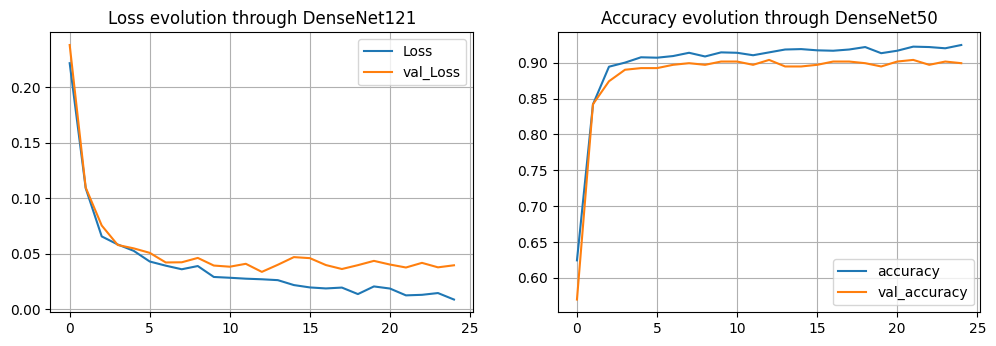

In [ ]:
#Visualizing the training performance
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history3.history['loss'], label='Loss')
plt.plot(history3.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution through DenseNet121')
plt.subplot(2, 2, 2)
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution through DenseNet50')